In [3]:
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

import torch, torchvision
from torch import nn, optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE=["#01BEFE","#FFDD00","#FF7D00","#FF006D","#ADFF02","#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 15, 10

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
!unzip /content/drive/MyDrive/archive.zip -d /content/dataset/



Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/seg_train/seg_train/mountain/7506.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7537.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7539.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7551.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7560.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7565.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7578.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7581.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7586.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7647.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7652.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7654.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7662.jpg  
  inflating: /content/dataset/seg_train

In [60]:
from glob import glob

train_folders = sorted(glob('/content/dataset/seg_train/seg_train/*'))
print(len(train_folders))  # To verify the number of classes or folders


6


In [61]:
def load_image(img_path, resize=True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    if resize:
        img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)

    return img

def show_image(img_path):
    img = load_image(img_path)
    plt.imshow(img)
    plt.axis('off')

def show_sign_grid(image_paths):
    images = [load_image(img) for img in image_paths]
    images = torch.as_tensor(images)
    images = images.permute(0,3,1,2)
    grid_img = torchvision.utils.make_grid(images, nrow=11)
    plt.figure(figsize=(24,12))
    plt.imshow(grid_img.permute(1,2,0))
    plt.axis('off')

6


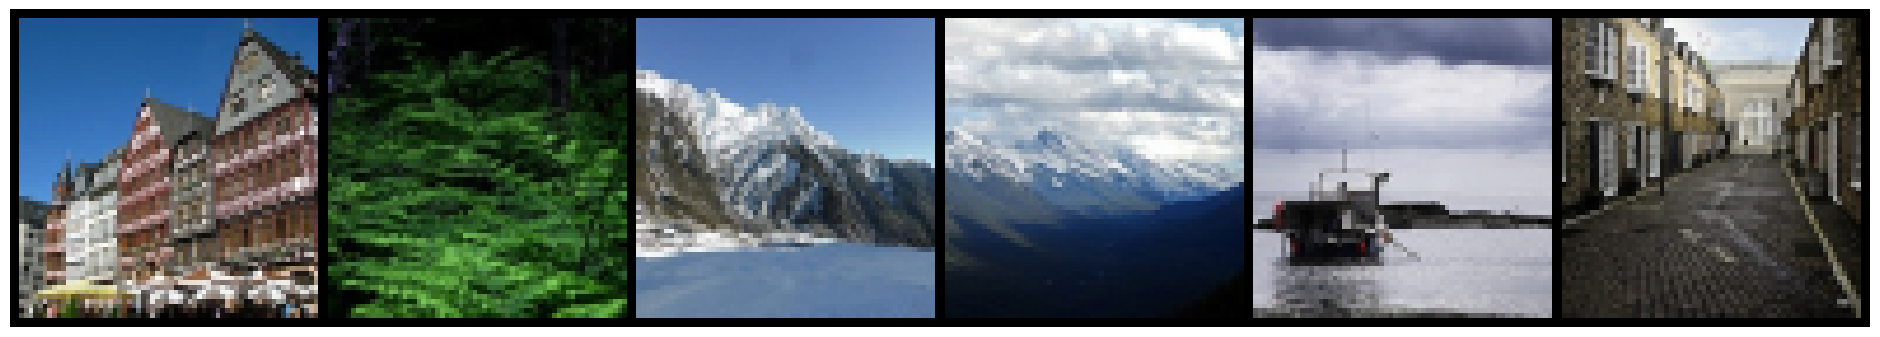

In [62]:
# Import necessary libraries
import numpy as np
from glob import glob

# Adjust this path to match where the dataset is extracted
train_folders = sorted(glob('/content/dataset/seg_train/seg_train/*'))
print(len(train_folders))  # This should print the number of class folders

# Load a random sample image from each folder and show the grid
sample_images = [np.random.choice(glob(f'{tf}/*.jpg')) for tf in train_folders]

# Assuming `show_sign_grid` is your function to display the images in a grid
show_sign_grid(sample_images)



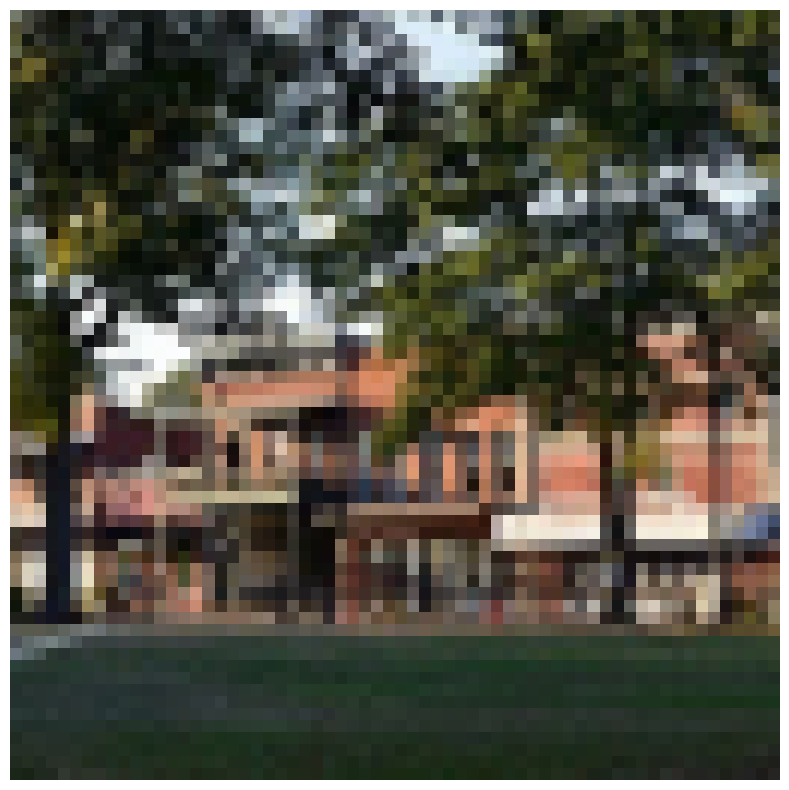

In [63]:
img_path = glob(f'{train_folders[0]}/*jpg')[1]

show_image(img_path)

In [64]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

class_indices = [0,1,2,3,4,5]

In [65]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val']

for ds in DATASETS:
    for cls in class_names:
        (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [66]:
for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f'{train_folders[cls_index]}/*jpg'))
    class_name = class_names[i]
    print(f'{class_name}: {len(image_paths)}')
    np.random.shuffle(image_paths)

    ds_split = np.split(
        image_paths,
        indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
    )

    dataset_data = zip(DATASETS, ds_split)
    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


In [67]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
    T.RandomResizedCrop(size=256),
    T.RandomRotation(degrees=15),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
    T.Resize(size=256),
    T.CenterCrop(size=224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
]),}

In [74]:
image_datasets = {
    d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
    d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) for d in DATASETS
}

In [75]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 11224, 'val': 1402}

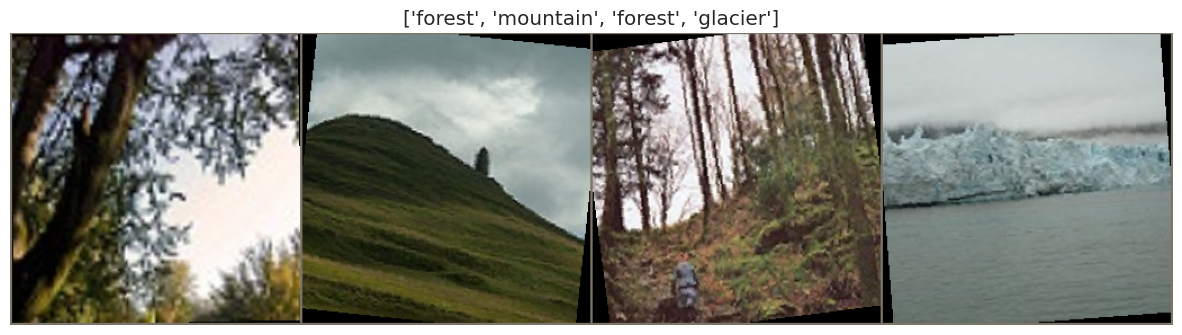

In [16]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [17]:
def create_model(n_classes):
    model = models.resnet34(pretrained=True)

    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

    return model.to(device)

In [18]:
base_model = create_model(len(class_names))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 41.6MB/s]


In [19]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train() #Convert to train mode
    losses = []
    correct_predictions = 0

    for inputs, labels in data_loader:
        inputs = inputs.to(device) #Push array to gpu
        labels = labels.to(device)

        outputs = model(inputs) #get prob of output per class

        _, preds = torch.max(outputs, dim=1) # get max of pred
        loss = loss_fn(outputs, labels) # get loss

        correct_predictions += torch.sum(preds==labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    scheduler.step()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() #Evaluation mode

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds==labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [20]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=5):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    loss_fn = nn.CrossEntropyLoss().to(device)

    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(model, data_loaders['train'], loss_fn,
                                            optimizer, device, scheduler, dataset_sizes['train'])

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(model, data_loaders['val'], loss_fn, device, dataset_sizes['val'])

        print(f'Val loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc

    print(f'Best val accuracy: {best_accuracy}')

    model.load_state_dict(torch.load('best_model_state.bin'))

    return model, history

In [21]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device, n_epochs=10)

Epoch 1/10
----------
Train loss 0.9404761650940072 accuracy 0.6679436920883821
Val loss 0.5067801001448379 accuracy 0.855206847360913

Epoch 2/10
----------
Train loss 0.6477080648560017 accuracy 0.7664825374198148
Val loss 0.5347195398350734 accuracy 0.8566333808844508

Epoch 3/10
----------
Train loss 0.5691026740798565 accuracy 0.8007840342124021
Val loss 0.32503396819869357 accuracy 0.9001426533523538

Epoch 4/10
----------
Train loss 0.49956317299782615 accuracy 0.8152173913043479
Val loss 0.27528436447931864 accuracy 0.9051355206847361

Epoch 5/10
----------
Train loss 0.4748791928209911 accuracy 0.8276906628652887
Val loss 0.3388676274455863 accuracy 0.905848787446505

Epoch 6/10
----------
Train loss 0.4561017745574661 accuracy 0.8348182466143977
Val loss 0.34406357128129994 accuracy 0.8994293865905849

Epoch 7/10
----------
Train loss 0.4256438883950805 accuracy 0.8467569493941555
Val loss 0.28638816576249077 accuracy 0.9158345221112696

Epoch 8/10
----------
Train loss 0.337

<ipython-input-20-9f35b401b1be>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_state.bin'))


In [22]:
import torch

# Assuming your model is named 'base_model'
model_path = 'model.pth'  # Define the path where you want to save the model
torch.save(base_model.state_dict(), model_path)


In [23]:
from google.colab import files
files.download(model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
model_path_drive = '/content/drive/My Drive/model.pth'
torch.save(base_model.state_dict(), model_path_drive)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

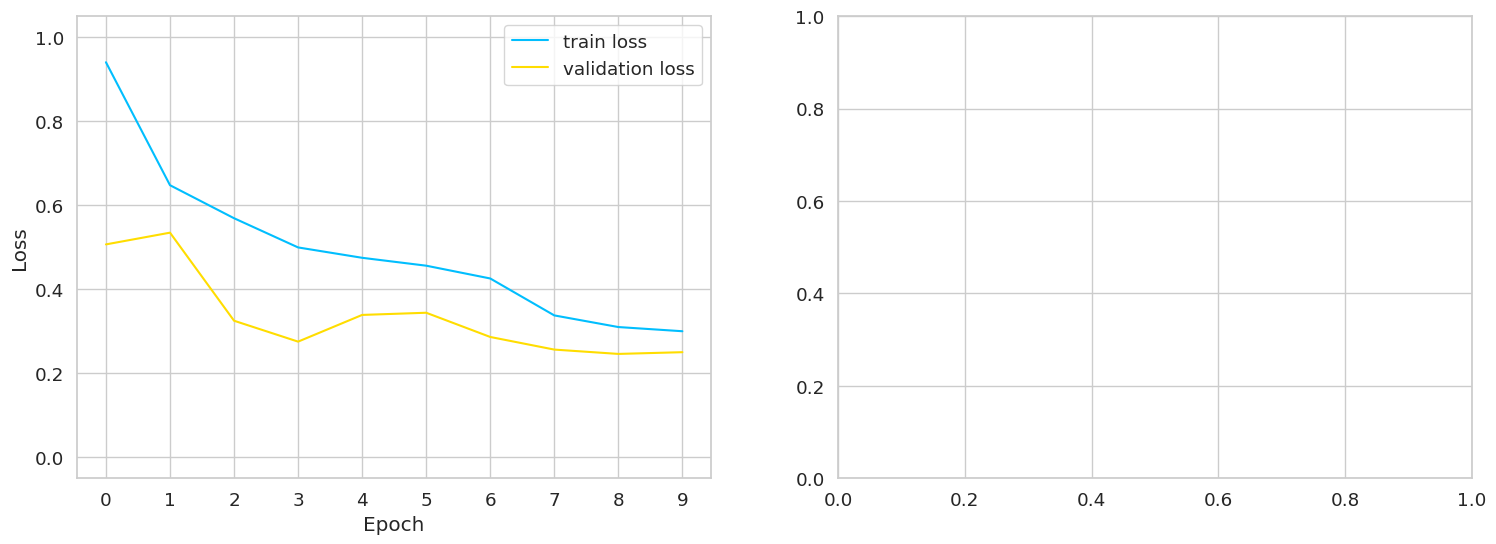

In [27]:
#Visualize Training History.
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='validation loss')

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.plot(history['train_acc'], label='train accuracy')
    ax2.plot(history['val_acc'], label='validation accuracy')

    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([-0.05, 1.05])
    ax2.legend()
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')

    fig.suptitle('Training History')

plot_training_history(history)

In [76]:
test_folders = sorted(glob('/content/dataset/seg_test/seg_test/*'))
len(test_folders)

6

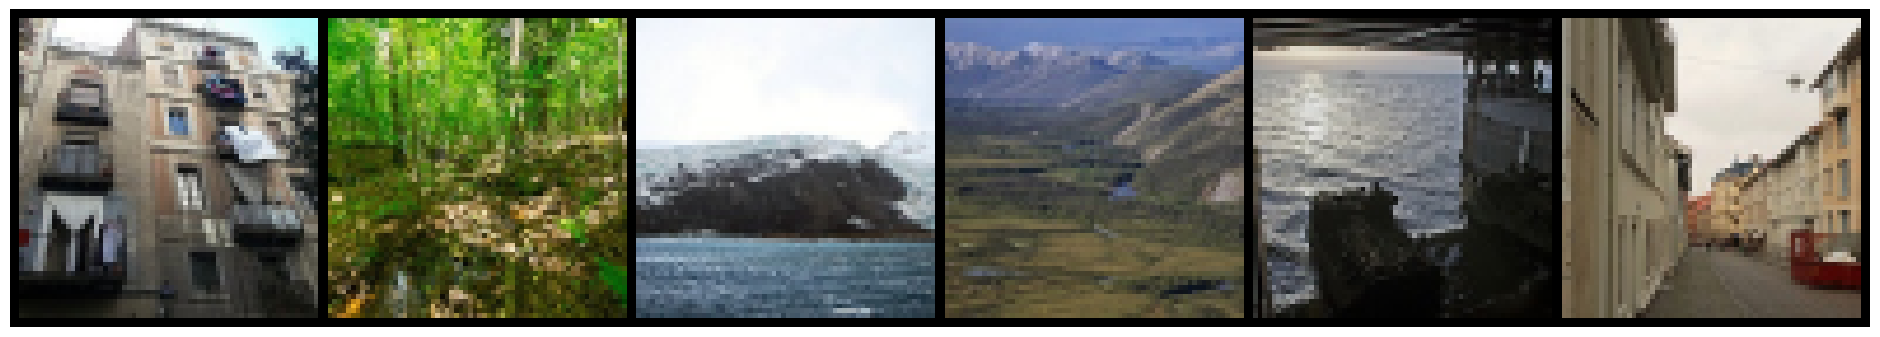

In [29]:
#Show Random Sample Image.
sample_images = [np.random.choice(glob(f'{tf}/*jpg')) for tf in test_folders]
show_sign_grid(sample_images)

In [79]:
#Class Classification.
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

class_indices = [0, 1, 2, 3, 4, 5]

#Test Directory.
DATASETS = ['test']

for ds in DATASETS:
    for cls in class_names:
        (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

#Class Distribution & Split.
for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f'{test_folders[cls_index]}/*jpg'))
    class_name = class_names[i]
    print(f'{class_name}: {len(image_paths)}')
    np.random.shuffle(image_paths)

    ds_split = np.split(
        image_paths,
        indices_or_sections=[int(.8 * len(image_paths)), int(.9 * len(image_paths))]
    )

    dataset_data = zip(DATASETS, ds_split)
    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

#Transforms.
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'test': T.Compose([
    T.Resize(size = 256),
    T.CenterCrop(size= 224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)]),
}

#Image Datasets.
image_datasets = {
    d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

#Data Loaders.
data_loaders = {
    d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) for d in DATASETS
}

#Dataset Sizes.
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['test'].classes

dataset_sizes

buildings: 437
forest: 474
glacier: 553
mountain: 525
sea: 510
street: 501


{'test': 2398}

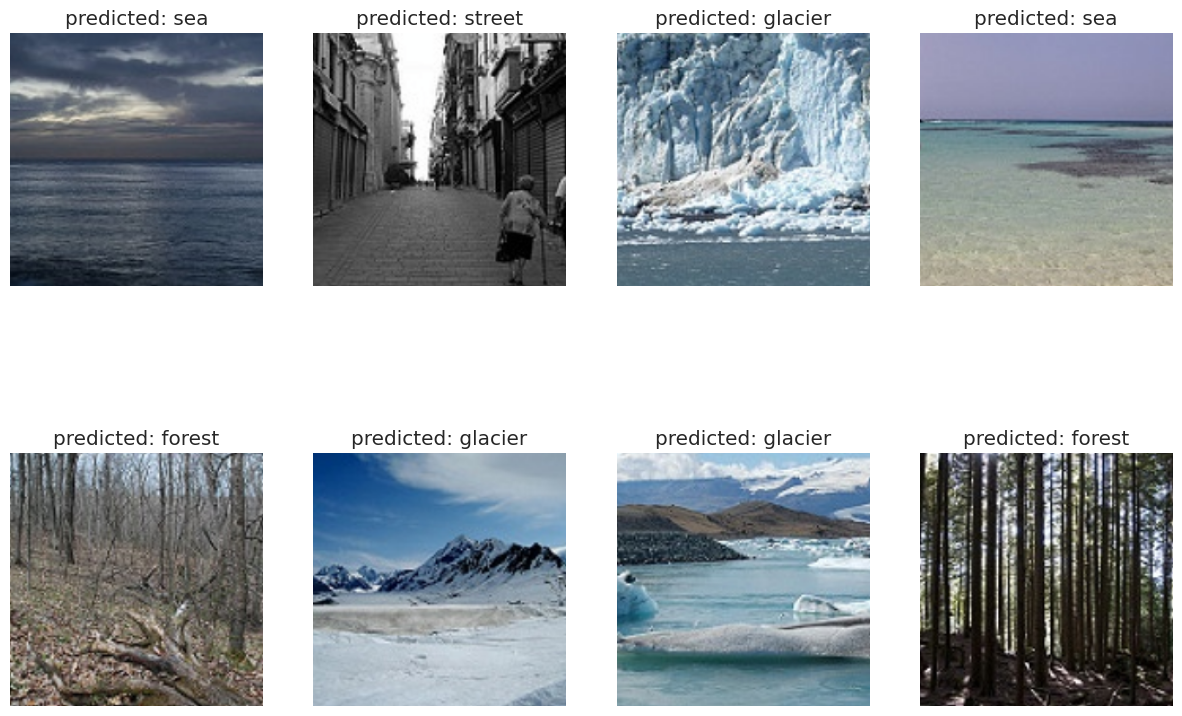

In [31]:
#Show Predictions.
def show_predictions(model, class_names, n_images=6):
    model = model.eval()
    images_handeled = 0
    plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            for j in range(inputs.shape[0]):
                images_handeled += 1
                ax = plt.subplot(2, n_images//2, images_handeled)
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                ax.axis('off')

                if images_handeled == n_images:
                    return

show_predictions(base_model, class_names, n_images=8)

In [32]:
#Classification Report.
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            predictions.extend(preds)
            real_values.extend(labels)
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()

    return predictions, real_values

In [33]:
# Testing on unmodified images

y_pred, y_test = get_predictions(base_model, data_loaders['test'])

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.92      0.92      0.92       349
      forest       0.99      0.99      0.99       379
     glacier       0.88      0.88      0.88       442
    mountain       0.89      0.87      0.88       420
         sea       0.93      0.96      0.95       408
      street       0.93      0.94      0.93       400

    accuracy                           0.92      2398
   macro avg       0.92      0.93      0.93      2398
weighted avg       0.92      0.92      0.92      2398



Introducing Adversarial attack on test dataset

In [34]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [35]:
## Full modified images

def get_predictions_adv(model, data_loader,epsilon):

    model = model.eval()
    predictions = []
    real_values = []
    loss_fn = nn.CrossEntropyLoss().to(device) # Will not be using this


    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        inputs.requires_grad = True

        # Forward pass the data through the model
        outputs = model(inputs)


        # Calculate the loss
        loss = loss_fn(outputs, labels)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = inputs.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(inputs, epsilon, data_grad)

        # Re-classify the perturbed image
        outputs = model(perturbed_data)

        ## New output

        _, preds = torch.max(outputs, dim=1) # get max of pred

        predictions.extend(preds)
        real_values.extend(labels)


    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()

    return predictions, real_values

In [36]:
## Testing model on full modified images

from sklearn.metrics import accuracy_score

epsilons = [0, .05, .1, .15, .2, .25, .3]
accuracy = []

# Run test for each epsilon
for eps in epsilons:
    print("For Epsilon =" +str(eps))
    y_pred, y_test = get_predictions_adv(base_model, data_loaders['test'],eps)

    acc = accuracy_score(y_pred,y_test)
    accuracy.append(acc)

    print(classification_report(y_test, y_pred, target_names=class_names))

For Epsilon =0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


              precision    recall  f1-score   support

   buildings       0.67      0.91      0.77       349
      forest       0.99      0.74      0.85       379
     glacier       0.70      0.82      0.76       442
    mountain       0.86      0.70      0.77       420
         sea       0.65      0.87      0.74       408
      street       0.89      0.54      0.67       400

    accuracy                           0.76      2398
   macro avg       0.79      0.76      0.76      2398
weighted avg       0.79      0.76      0.76      2398

For Epsilon =0.05


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


              precision    recall  f1-score   support

   buildings       0.54      0.83      0.66       349
      forest       0.96      0.65      0.77       379
     glacier       0.49      0.63      0.55       442
    mountain       0.65      0.49      0.56       420
         sea       0.49      0.65      0.56       408
      street       0.70      0.30      0.42       400

    accuracy                           0.59      2398
   macro avg       0.64      0.59      0.59      2398
weighted avg       0.63      0.59      0.58      2398

For Epsilon =0.1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


              precision    recall  f1-score   support

   buildings       0.49      0.79      0.60       349
      forest       0.91      0.60      0.72       379
     glacier       0.40      0.51      0.45       442
    mountain       0.55      0.41      0.47       420
         sea       0.40      0.55      0.46       408
      street       0.57      0.20      0.30       400

    accuracy                           0.50      2398
   macro avg       0.55      0.51      0.50      2398
weighted avg       0.55      0.50      0.49      2398

For Epsilon =0.15


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


              precision    recall  f1-score   support

   buildings       0.46      0.74      0.57       349
      forest       0.85      0.55      0.67       379
     glacier       0.33      0.43      0.37       442
    mountain       0.51      0.37      0.43       420
         sea       0.35      0.50      0.41       408
      street       0.46      0.14      0.22       400

    accuracy                           0.45      2398
   macro avg       0.49      0.46      0.44      2398
weighted avg       0.49      0.45      0.44      2398

For Epsilon =0.2


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


              precision    recall  f1-score   support

   buildings       0.43      0.70      0.54       349
      forest       0.80      0.49      0.61       379
     glacier       0.30      0.37      0.33       442
    mountain       0.50      0.35      0.41       420
         sea       0.31      0.49      0.38       408
      street       0.39      0.11      0.17       400

    accuracy                           0.41      2398
   macro avg       0.45      0.42      0.41      2398
weighted avg       0.45      0.41      0.40      2398

For Epsilon =0.25


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


              precision    recall  f1-score   support

   buildings       0.43      0.68      0.53       349
      forest       0.72      0.47      0.57       379
     glacier       0.28      0.33      0.30       442
    mountain       0.48      0.31      0.38       420
         sea       0.29      0.49      0.36       408
      street       0.36      0.09      0.15       400

    accuracy                           0.39      2398
   macro avg       0.43      0.40      0.38      2398
weighted avg       0.42      0.39      0.38      2398

For Epsilon =0.3


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


              precision    recall  f1-score   support

   buildings       0.43      0.66      0.52       349
      forest       0.65      0.45      0.54       379
     glacier       0.28      0.32      0.30       442
    mountain       0.49      0.30      0.37       420
         sea       0.28      0.51      0.36       408
      street       0.32      0.08      0.12       400

    accuracy                           0.38      2398
   macro avg       0.41      0.39      0.37      2398
weighted avg       0.40      0.38      0.36      2398



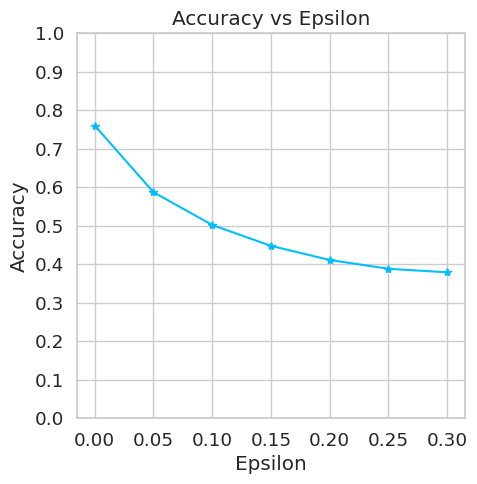

In [37]:
## Plot epsilon accuracy graph

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracy, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Testing on mixture of modified and unmodified images

In [38]:
## Test sets with combination of modified images and unmodified images
import random

def get_predictions_random(model, data_loader):

    model = model.eval()
    predictions = []
    real_values = []

    loss_fn = nn.CrossEntropyLoss().to(device)

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get probability
        prob = random.uniform(0,1)

        if prob <0.5:

            ##Generate random epsilon
            epsilon = random.uniform(0,0.3)

            # Set requires_grad attribute of tensor. Important for Attack
            inputs.requires_grad = True

            # Forward pass the data through the model
            outputs = model(inputs)


            # Calculate the loss
            loss = loss_fn(outputs, labels)

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect datagrad
            data_grad = inputs.grad.data

            # Call FGSM Attack
            perturbed_data = fgsm_attack(inputs, epsilon, data_grad)

            # Re-classify the perturbed image
            outputs = model(perturbed_data)

            ## New output
            _, preds = torch.max(outputs, 1)


            predictions.extend(preds)
            real_values.extend(labels)

        else:
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            predictions.extend(preds)
            real_values.extend(labels)


    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()

    return predictions, real_values

In [39]:
# Report using combination of modified and unmodified images

y_pred, y_test = get_predictions_random(base_model, data_loaders['test'])
print(classification_report(y_test, y_pred, target_names=class_names))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


              precision    recall  f1-score   support

   buildings       0.64      0.82      0.72       349
      forest       0.93      0.80      0.86       379
     glacier       0.59      0.66      0.62       442
    mountain       0.76      0.63      0.69       420
         sea       0.60      0.77      0.68       408
      street       0.84      0.55      0.66       400

    accuracy                           0.70      2398
   macro avg       0.73      0.70      0.70      2398
weighted avg       0.72      0.70      0.70      2398



Training a model with mixture of modified and unmodified images

In [46]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train() #Convert to train mode
    losses = []
    correct_predictions = 0

    for inputs, labels in data_loader:

        prob = random.uniform(0,1) ## generating probability

        inputs = inputs.to(device) #Push array to gpu
        labels = labels.to(device)

        if prob < 0.5:

            epsilon = random.uniform(0,0.3) ## generating random epsilon

            # Set requires_grad attribute of tensor. Important for Attack
            inputs.requires_grad = True

            # Forward pass the data through the model
            outputs = model(inputs)


            # Calculate the loss
            loss = loss_fn(outputs, labels)

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect datagrad
            data_grad = inputs.grad.data

            # Call FGSM Attack
            perturbed_data = fgsm_attack(inputs, epsilon, data_grad)

            # Re-classify the perturbed image
            outputs = model(perturbed_data)


            _, preds = torch.max(outputs, dim=1) # get max of pred
            correct_predictions += torch.sum(preds==labels)


            loss = loss_fn(outputs, labels) # get loss
            losses.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        else :

            outputs = model(inputs) #get prob of output per class


            loss = loss_fn(outputs, labels) # get loss
            losses.append(loss.item())

            _, preds = torch.max(outputs, dim=1) # get max of pred
            correct_predictions += torch.sum(preds==labels)


            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    scheduler.step()

    return correct_predictions.double() / n_examples, np.nanmean(losses)



def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() #Evaluation mode
    losses = []
    correct_predictions = 0


    for inputs, labels in data_loader:

        prob = random.uniform(0,1) ## generating probability

        inputs = inputs.to(device)
        labels = labels.to(device)


        if prob <0.5:

            epsilon = random.uniform(0,0.3) ## generating random epsilon

            # Set requires_grad attribute of tensor. Important for Attack
            inputs.requires_grad = True

            # Forward pass the data through the model
            outputs = model(inputs)


            # Calculate the loss
            loss = loss_fn(outputs, labels)

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect datagrad
            data_grad = inputs.grad.data

            # Call FGSM Attack
            perturbed_data = fgsm_attack(inputs, epsilon, data_grad)

            # Re-classify the perturbed image
            outputs = model(perturbed_data)

            _, preds = torch.max(outputs, dim=1)

            correct_predictions += torch.sum(preds==labels)

            loss = loss_fn(outputs,labels)
            losses.append(loss.item())

        else:

            outputs = model(inputs)

            loss = loss_fn(outputs,labels)
            losses.append(loss.item())

            _, preds = torch.max(outputs, dim=1)

            correct_predictions += torch.sum(preds==labels)


    return correct_predictions.double() / n_examples, np.nanmean(losses)

In [47]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=5):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    loss_fn = nn.CrossEntropyLoss().to(device)
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(model, data_loaders['train'], loss_fn,
                                            optimizer, device, scheduler, dataset_sizes['train'])

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(model, data_loaders['val'], loss_fn, device, dataset_sizes['val'])

        print(f'Val loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc

    print(f'Best val accuracy: {best_accuracy}')

    model.load_state_dict(torch.load('best_model_state.bin'))

    return model, history

In [53]:
print("Data Loaders Keys:", data_loaders.keys())


Data Loaders Keys: dict_keys(['test'])


In [70]:

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device, n_epochs=10)

Epoch 1/10
----------
Train loss 0.8249970030484964 accuracy 0.6935138987883108
Val loss 0.716140516232991 accuracy 0.746077032810271

Epoch 2/10
----------
Train loss 0.7461816558500032 accuracy 0.7161439771917321
Val loss 0.9505119569827816 accuracy 0.7154065620542083

Epoch 3/10
----------
Train loss 0.6888415959982483 accuracy 0.7361903064861013
Val loss 0.6016357481772175 accuracy 0.7796005706134095

Epoch 4/10
----------
Train loss 0.6498274884989229 accuracy 0.754632929436921
Val loss 0.608914164388141 accuracy 0.7831669044222539

Epoch 5/10
----------
Train loss 0.6297945588928696 accuracy 0.7632751247327156
Val loss 0.6071000264637819 accuracy 0.7817403708987162

Epoch 6/10
----------
Train loss 0.6157536052780151 accuracy 0.7694226657163222
Val loss 0.6010558352164892 accuracy 0.7895863052781741

Epoch 7/10
----------
Train loss 0.5989877329657811 accuracy 0.7717391304347826
Val loss 0.7273483152570603 accuracy 0.7738944365192583

Epoch 8/10
----------
Train loss 0.4968868572

<ipython-input-47-4c03ac4eac5a>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_state.bin'))


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

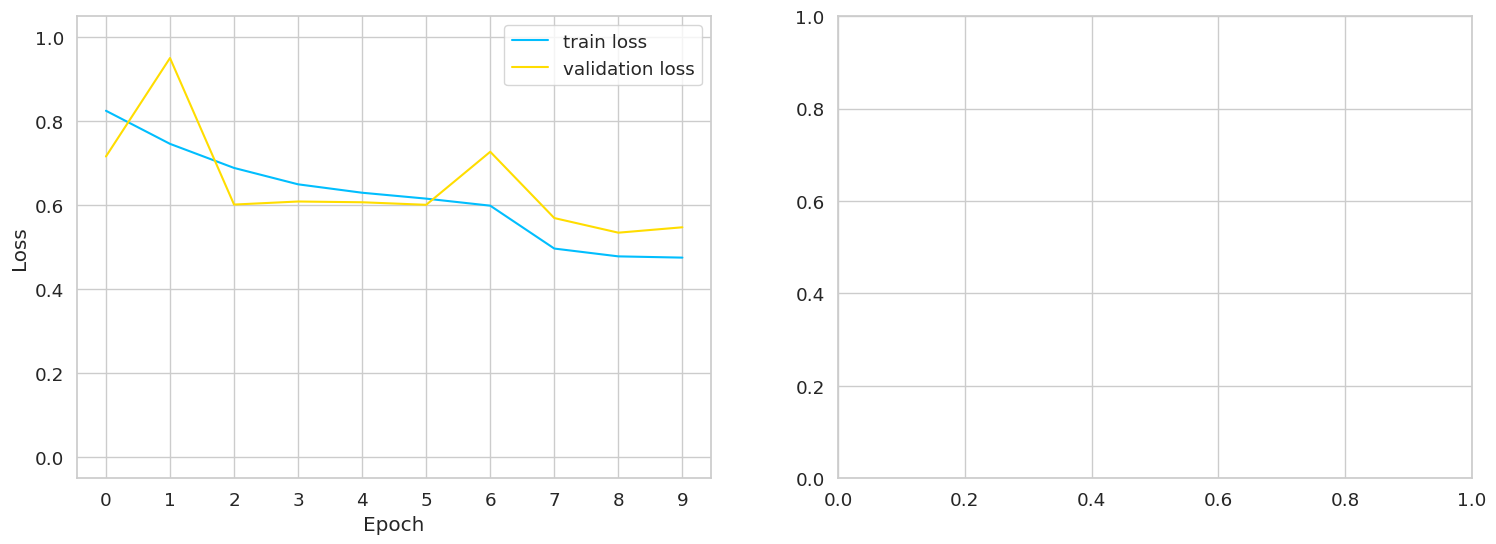

In [71]:
#Visualize Training History.
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='validation loss')

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.plot(history['train_acc'], label='train accuracy')
    ax2.plot(history['val_acc'], label='validation accuracy')

    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([-0.05, 1.05])
    ax2.legend()
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')

    fig.suptitle('Training History')

plot_training_history(history)

Testing model using a combination of unmodified and modified images

In [80]:
## Result(Mixture of modified and unmodified images)

y_pred, y_test = get_predictions_random(base_model, data_loaders['test'])
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.76      0.84      0.80       349
      forest       0.95      0.89      0.92       379
     glacier       0.84      0.70      0.76       442
    mountain       0.82      0.72      0.76       420
         sea       0.70      0.89      0.79       408
      street       0.82      0.82      0.82       400

    accuracy                           0.81      2398
   macro avg       0.81      0.81      0.81      2398
weighted avg       0.81      0.81      0.81      2398



In [81]:
print("Data Loaders Keys:", data_loaders.keys())

Data Loaders Keys: dict_keys(['test'])


Testing model using full set of unmodified images

In [84]:
## Test sets with full modified images

def get_predictions_adv2(model, data_loader):

    model = model.eval()
    predictions = []
    real_values = []

    loss_fn = nn.CrossEntropyLoss().to(device)

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)



        ##Generate random epsilon
        epsilon = random.uniform(0,0.3)

        # Set requires_grad attribute of tensor. Important for Attack
        inputs.requires_grad = True

        # Forward pass the data through the model
        outputs = model(inputs)


        # Calculate the loss
        loss = loss_fn(outputs, labels)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = inputs.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(inputs, epsilon, data_grad)

        # Re-classify the perturbed image
        outputs = model(perturbed_data)

        ## New output
        _, preds = torch.max(outputs, 1)


        predictions.extend(preds)
        real_values.extend(labels)




    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()

    return predictions, real_values

In [85]:
## Result(Full randomly modified images)

y_pred, y_test = get_predictions_adv2(base_model, data_loaders['test'])
print(classification_report(y_test, y_pred, target_names=class_names))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


              precision    recall  f1-score   support

   buildings       0.61      0.78      0.68       349
      forest       0.94      0.79      0.86       379
     glacier       0.77      0.54      0.63       442
    mountain       0.78      0.61      0.68       420
         sea       0.55      0.84      0.67       408
      street       0.72      0.68      0.70       400

    accuracy                           0.70      2398
   macro avg       0.73      0.71      0.70      2398
weighted avg       0.73      0.70      0.70      2398



# New Section